# Process ATAC-Seq Data Files
### Calculating the average number of ATAC-seq peaks that exist at a given chromosomal location across all samples

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Get a list of all .txt files in the current directory
txt_files = [file for file in os.listdir() if file.endswith(".txt")]

# Initialize a dictionary to store total peak values for each chromosome and peak
total_peak_values = {}
peak_counts = {}

# Process each file
for txt_file in txt_files:
    # Read the data from the current file
    file_path = os.path.join(os.getcwd(), txt_file)
    data = pd.read_csv(file_path, sep="\t", header=None, names=['chrom', 'start', 'end', 'peak_id', 'value'])

    # Process each row in the file
    for index, row in data.iterrows():
        chrom, start, end, peak_id, value = row

        # Use the peak ID as a unique identifier for peaks
        peak_key = (chrom, start, end, peak_id)
        
        if peak_key not in total_peak_values:
            total_peak_values[peak_key] = 0
            peak_counts[peak_key] = 0
        
        total_peak_values[peak_key] += value
        peak_counts[peak_key] += 1

# Calculate average peak values for each peak
average_peak_values = {peak_key: total / peak_counts[peak_key] for peak_key, total in total_peak_values.items()}

# Convert to DataFrame for easier handling and plotting
average_peak_df = pd.DataFrame(average_peak_values.items(), columns=['Peak_Info', 'Average_Value'])
average_peak_df[['Chrom', 'Start', 'End', 'Peak_ID']] = pd.DataFrame(average_peak_df['Peak_Info'].tolist(), index=average_peak_df.index)
average_peak_df.drop('Peak_Info', axis=1, inplace=True)

# grouped = average_peak_df.groupby('Chrom')



In [2]:
average_peak_df

,Average_Value,Chrom,Start,End,Peak_ID
0,0.815789,chr1,17239,17739,PCPG_2
1,0.000000,chr1,102710,103210,LIHC_2
2,0.000000,chr1,136495,136995,LIHC_3
3,2.947368,chr1,180654,181154,TGCT_2
4,3.394737,chr1,181203,181703,LGG_2
...,...,...,...,...,...
562704,0.210526,chrX,156005168,156005668,PCPG_87383
562705,0.000000,chrX,156008315,156008815,PCPG_87384
562706,0.526316,chrX,156025205,156025705,THCA_93794
562707,0.184211,chrX,156029186,156029686,TGCT_74401


In [3]:
import numpy as np

# Define the window size (1 Mb = 1,000,000 base pairs)
window_size = 1_000_000

# Initialize a list to store the results
window_averages = []

# Iterate over each chromosome present in the DataFrame
for chrom in average_peak_df['Chrom'].unique():
    # Filter the DataFrame for the current chromosome
    chrom_df = average_peak_df[average_peak_df['Chrom'] == chrom]

    # Find the max position for the current chromosome to define the last window
    max_position = chrom_df['End'].max()

    # Create windows of 1Mb along the chromosome
    for window_start in range(0, max_position, window_size):
        window_end = window_start + window_size

        # Filter peaks within the current window
        # A peak is considered within the window if its start is <= window_end and its end > window_start
        window_peaks = chrom_df[(chrom_df['Start'] <= window_end) & (chrom_df['End'] > window_start)]

        # Calculate the average of the average peak values within this window
        if not window_peaks.empty:
            window_avg = window_peaks['Average_Value'].mean()
            window_averages.append({'Chrom': chrom, 'Window_Start': window_start, 'Window_End': window_end, 'Average_Peak_Value': window_avg})

# Convert the results into a DataFrame
window_averages_df = pd.DataFrame(window_averages)

# Now have DataFrame with the average of the average peak values for each 1 Mb window along the genome
# Rename the 'Window_Start' column and drop the 'Window_End' column
window_averages_df.rename(columns={'Chrom':'chrom','Window_Start': 'window_index', 'Average_Peak_Value': 'average_peak_count'}, inplace=True)
window_averages_df.drop('Window_End', axis=1, inplace=True)
window_averages_df['window_index'] = window_averages_df['window_index']/1e6
# Col Adjust
avg_peak_counts_df = window_averages_df
print(avg_peak_counts_df)

     chrom  window_index  average_peak_count
0     chr1           0.0            4.601876
1     chr1           1.0           11.100515
2     chr1           2.0            4.723746
3     chr1           3.0            3.599641
4     chr1           4.0            0.131068
...    ...           ...                 ...
2900  chrX         152.0            0.955903
2901  chrX         153.0            4.242441
2902  chrX         154.0            5.363129
2903  chrX         155.0            2.004912
2904  chrX         156.0            0.681579

[2905 rows x 3 columns]


In [4]:
avg_peak_counts_df

,chrom,window_index,average_peak_count
0,chr1,0.0,4.601876
1,chr1,1.0,11.100515
2,chr1,2.0,4.723746
3,chr1,3.0,3.599641
4,chr1,4.0,0.131068
...,...,...,...
2900,chrX,152.0,0.955903
2901,chrX,153.0,4.242441
2902,chrX,154.0,5.363129
2903,chrX,155.0,2.004912


# Process Metastatic Mutation SNV Information

### SNVs previously processed by finding the average number of mutations for 1-Mb windows along the genome across all samples for a given patient via Hartwig Medical Foundation data. After repeating this for all patients, another average is then computed across patients, finding the average number of mutations per 1-Mb window per patient along the genome. Exported to JSON file for easy access. This code can be seen in ``` metastatic_SNV_process.py ```


In [5]:
import pandas as pd

# Specify the path to your JSON file

json_file_path = '/Users/suryav/proj/total_SNV_average_count.json'


# Load the JSON file into a DataFrame
df = pd.read_json(json_file_path)

# Display the first few rows of the DataFrame to verify
#print(df.head())

mutation_df = df

# mutation_df = mutation_df.rename(columns={"chromosome":"chrom", "normalized_mutation_count":"normalized_density"})

mutation_df = mutation_df.rename(columns={"chromosome":"chrom"})


# mutation_df['chrom'] = 'chr' + mutation_df['chrom']

mutation_df = mutation_df.sort_values(by=['chrom', 'window_index'])

mutation_df = mutation_df[mutation_df['chrom'] != 'chrY']

mutation_df['normalized_mutation_count'] = mutation_df['normalized_mutation_count']
#####

merged_df = pd.merge(avg_peak_counts_df, mutation_df, on=['chrom', 'window_index'], how='inner')

#merged_df = pd.merge(merged_df, mutation_df2, on=['chrom', 'window_index'], how='inner')

print(merged_df)


     chrom  window_index  average_peak_count  normalized_mutation_count
0     chr1           0.0            4.601876                   2.609890
1     chr1           1.0           11.100515                   6.933379
2     chr1           2.0            4.723746                   8.198718
3     chr1           3.0            3.599641                   7.533196
4     chr1           4.0            0.131068                  12.891484
...    ...           ...                 ...                        ...
2851  chrX         151.0            1.439041                   9.230769
2852  chrX         152.0            0.955903                   5.527701
2853  chrX         153.0            4.242441                   5.296245
2854  chrX         154.0            5.363129                   6.863095
2855  chrX         155.0            2.004912                   2.639881

[2856 rows x 4 columns]


In [6]:
mutation_df

,chrom,window_index,normalized_mutation_count
205,chr1,0,2.609890
0,chr1,1,6.933379
1,chr1,2,8.198718
206,chr1,3,7.533196
2,chr1,4,12.891484
...,...,...,...
2883,chrX,151,9.230769
2884,chrX,152,5.527701
2885,chrX,153,5.296245
2886,chrX,154,6.863095


# Visualization: Avg. Metastatic Mutation Distribution vs. Avg. Primary Colorectal Chromatin Accessibility (ATAC-seq)

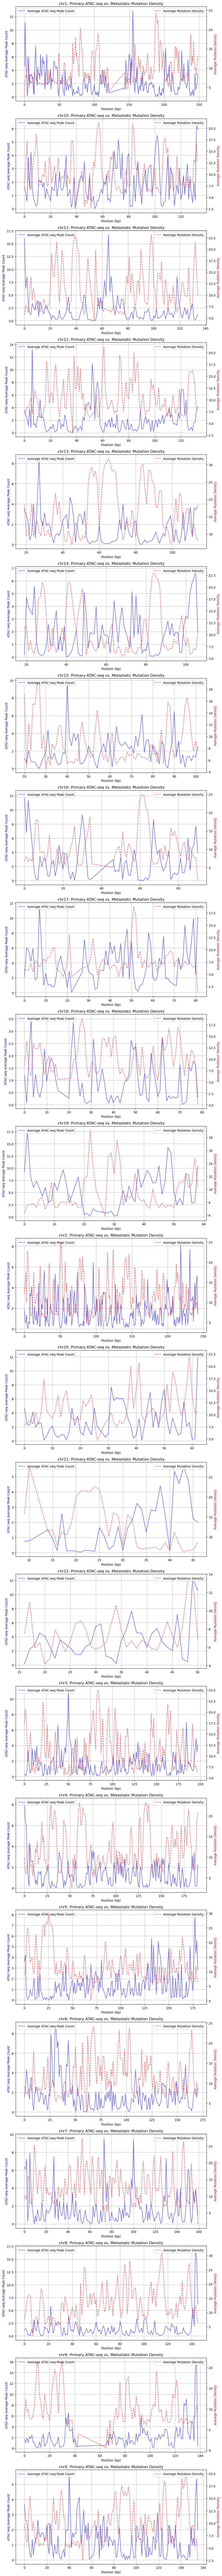

In [7]:
import matplotlib.pyplot as plt

# Assuming avg_peak_counts_df and mutation_df have been prepared and merged into merged_df appropriately

# Determine the chromosomes to plot
chromosomes = sorted(set(merged_df['chrom']))

# Determine the number of subplots needed
num_subplots = len(chromosomes)

# Create subplots. Adjusted figsize to ensure each subplot is clearly visible.
fig, axes = plt.subplots(num_subplots, 1, figsize=(10, 5 * num_subplots), squeeze=False)
axes = axes.flatten()

for i, chrom in enumerate(chromosomes):
    # Filter data for the current chromosome
    chrom_data = merged_df[merged_df['chrom'] == chrom].sort_values(by='window_index')
    
    ax1 = axes[i]
    ax2 = ax1.twinx()  # Create a twin of the original axis that shares the X-axis
    
    # Plot ATAC-seq average peak counts on the primary axis
    ax1.plot(chrom_data['window_index'], chrom_data['average_peak_count'], label='Average ATAC-seq Peak Count', linestyle='-', color='blue', alpha=0.6)
    
    # Plot normalized mutation densities on the secondary axis
    ax2.plot(chrom_data['window_index'], chrom_data['normalized_mutation_count'], label='Average Mutation Density', linestyle='--', color='red', alpha=0.6)
    
    # Set titles, labels, and legends
    ax1.set_title(f'{chrom}: Primary ATAC-seq vs. Metastatic Mutation Density')
    ax1.set_xlabel('Position (bp)')
    ax1.set_ylabel('ATAC-seq Average Peak Count', color='blue')
    ax2.set_ylabel('Average Mutation Density', color='red')
    
    # Add legends
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    
    ax1.grid(True)

# Adjust layout to prevent overlapping of subplots
plt.tight_layout()
plt.show()


# Spearman Correlation: Primary Colorectal Cancer Chromatin Accessibility (ATAC-seq data) & Average Metastatic Mutation Distribution

In [8]:
from scipy.stats import spearmanr

spearman_corr, p_value = spearmanr(merged_df['average_peak_count'], merged_df['normalized_mutation_count'])
print(spearman_corr, p_value)

-0.643186212150318 0.0


# Processing Healthy Colorectal ATAC-seq Data via Data from Pan-Cancer Analysis of Whole Genomes (PCAWG)

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Set the window size
window_size = 1000000  # 1 Mb

# Path to the .beb file
beb_file = '/Users/suryav/proj/ColoRect-AdenoCA_PCAWG_SNV.beb'

# Read the data from the .beb file
data = pd.read_csv(beb_file, sep="\t", header=None, names=['chrom', 'start', 'end', 'ref', 'alt', 'id', 'type'])

# Initialize a dictionary to store SNV counts for each chromosome and window
snv_counts = {}

# Process each chromosome in the file
for chrom in data['chrom'].unique():
    chrom_data = data[data['chrom'] == chrom]

    # Adjust window calculation to include SNVs that intersect with the window
    max_pos = chrom_data['start'].max()
    for start in range(0, max_pos, window_size):
        end = start + window_size
        # Count SNVs that intersect with the window
        snvs_in_window = chrom_data[(chrom_data['start'] < end) & (chrom_data['start'] >= start)].shape[0]
        
        # Update the SNV count in the dictionary
        if chrom not in snv_counts:
            snv_counts[chrom] = {}
        if start not in snv_counts[chrom]:
            snv_counts[chrom][start] = 0
        snv_counts[chrom][start] += snvs_in_window




In [10]:
import pandas as pd


# Convert the snv_counts dictionary to a list of records
records = []
for chrom, windows in snv_counts.items():
    for start, count in windows.items():
        record = {'chrom': chrom, 'window_index': start, 'snv_count': count}
        records.append(record)

# Convert the list of records to a DataFrame
snv_counts_df = pd.DataFrame(records)

# Sort the DataFrame for better readability
snv_counts_df = snv_counts_df.sort_values(by=['chrom', 'window_index']).reset_index(drop=True)
snv_counts_df['window_index'] =  snv_counts_df['window_index']/1e6
print(snv_counts_df)


     chrom  window_index  snv_count
0     chr1           0.0        415
1     chr1           1.0       1095
2     chr1           2.0       1502
3     chr1           3.0       1537
4     chr1           4.0       3483
...    ...           ...        ...
3105  chrY          55.0          0
3106  chrY          56.0          0
3107  chrY          57.0          0
3108  chrY          58.0         76
3109  chrY          59.0        134

[3110 rows x 3 columns]


In [11]:
snv_counts_df['snv_count'] = snv_counts_df['snv_count']/52 # There are 52 total patients, take average to find average # SNV per patient

In [12]:
snv_counts_df

,chrom,window_index,snv_count
0,chr1,0.0,7.980769
1,chr1,1.0,21.057692
2,chr1,2.0,28.884615
3,chr1,3.0,29.557692
4,chr1,4.0,66.980769
...,...,...,...
3105,chrY,55.0,0.000000
3106,chrY,56.0,0.000000
3107,chrY,57.0,0.000000
3108,chrY,58.0,1.461538


In [13]:
merged_df = pd.merge(avg_peak_counts_df, snv_counts_df, on=['chrom', 'window_index'], how='inner')

merged_df

,chrom,window_index,average_peak_count,snv_count
0,chr1,0.0,4.601876,7.980769
1,chr1,1.0,11.100515,21.057692
2,chr1,2.0,4.723746,28.884615
3,chr1,3.0,3.599641,29.557692
4,chr1,4.0,0.131068,66.980769
...,...,...,...,...
2890,chrX,151.0,1.439041,37.980769
2891,chrX,152.0,0.955903,22.730769
2892,chrX,153.0,4.242441,19.230769
2893,chrX,154.0,5.363129,36.442308


In [14]:
mutation_df

,chrom,window_index,normalized_mutation_count
205,chr1,0,2.609890
0,chr1,1,6.933379
1,chr1,2,8.198718
206,chr1,3,7.533196
2,chr1,4,12.891484
...,...,...,...
2883,chrX,151,9.230769
2884,chrX,152,5.527701
2885,chrX,153,5.296245
2886,chrX,154,6.863095


# Spearman Correlation Between the Primary Cancer Mutations and the Metastatic Cancer Mutations

In [15]:
asdf = pd.merge(mutation_df, snv_counts_df, on=['chrom', 'window_index'], how='inner')
from scipy.stats import spearmanr
spearman_corr, p_value = spearmanr(asdf['normalized_mutation_count'], asdf['snv_count'])
print(spearman_corr, p_value)

0.9044299907659363 0.0


# Spearman Correlation Between Primary Chromatin Accessibility and the Primary Cancer Mutation Distribution

In [16]:
from scipy.stats import spearmanr
spearman_corr, p_value = spearmanr(merged_df['average_peak_count'], merged_df['snv_count'])
print(spearman_corr, p_value)

-0.6108992588763907 8.593858044591441e-296


In [17]:
primaryChrom_v_primaryCancerMut = pd.merge(avg_peak_counts_df, mutation_df, on=['chrom', 'window_index'], how='inner')
primaryChrom_v_primaryCancerMut

,chrom,window_index,average_peak_count,normalized_mutation_count
0,chr1,0.0,4.601876,2.609890
1,chr1,1.0,11.100515,6.933379
2,chr1,2.0,4.723746,8.198718
3,chr1,3.0,3.599641,7.533196
4,chr1,4.0,0.131068,12.891484
...,...,...,...,...
2851,chrX,151.0,1.439041,9.230769
2852,chrX,152.0,0.955903,5.527701
2853,chrX,153.0,4.242441,5.296245
2854,chrX,154.0,5.363129,6.863095


# Correlation Between Primary Colorectal Cancer Chromatin Accessibility (ATAC-seq data) and Average Metastatic Mutation Distribution

In [18]:
spearman_corr, p_value = spearmanr(primaryChrom_v_primaryCancerMut['average_peak_count'], primaryChrom_v_primaryCancerMut['normalized_mutation_count'])
print(spearman_corr, p_value)

-0.643186212150318 0.0


# 1D H3k27ac Signal Enrichment

In [19]:
import pandas as pd

# Load the .bed file into a DataFrame

bed_file = '/Users/suryav/proj/col_adeno_HiChIP/BIGGIE.bed'

# Define the window size in base pairs (1 Mb)
# Set the window size
window_size = 1000000  # 1 Mb

# Read the data from the .beb file
data = pd.read_csv(bed_file, sep="\t", header=None, names=['chrom', 'start', 'end'])

# Initialize a dictionary to store h3k counts for each chromosome and window
h3k_counts = {}

# Process each chromosome in the file
for chrom in data['chrom'].unique():
    chrom_data = data[data['chrom'] == chrom]

    # Adjust window calculation to include h3ks that intersect with the window
    max_pos = chrom_data['start'].max()
    for start in range(0, max_pos, window_size):
        end = start + window_size
        # Count h3ks that intersect with the window
        h3ks_in_window = chrom_data[(chrom_data['start'] < end) & (chrom_data['start'] >= start)].shape[0]
        
        # Update the h3k count in the dictionary
        if chrom not in h3k_counts:
            h3k_counts[chrom] = {}
        if start not in h3k_counts[chrom]:
            h3k_counts[chrom][start] = 0
        h3k_counts[chrom][start] += h3ks_in_window

In [20]:
rpkm_data = []
for chrom, windows in h3k_counts.items():
    for start, rage in windows.items():
        rpkm_data.append({'chrom': chrom, 'window_index': start // window_size, 'rpkm': rage})
rpkm_df = pd.DataFrame(rpkm_data)

In [21]:
rpkm_df

,chrom,window_index,rpkm
0,chr1,0,0
1,chr1,1,6093
2,chr1,2,5240
3,chr1,3,9
4,chr1,4,0
...,...,...,...
2989,chrX,150,0
2990,chrX,151,0
2991,chrX,152,0
2992,chrX,153,0


In [22]:
rpkm_v_atac = pd.merge(avg_peak_counts_df, rpkm_df, on=['chrom', 'window_index'], how='inner')
rpkm_v_atac

,chrom,window_index,average_peak_count,rpkm
0,chr1,0.0,4.601876,0
1,chr1,1.0,11.100515,6093
2,chr1,2.0,4.723746,5240
3,chr1,3.0,3.599641,9
4,chr1,4.0,0.131068,0
...,...,...,...,...
2851,chrX,150.0,0.981963,0
2852,chrX,151.0,1.439041,0
2853,chrX,152.0,0.955903,0
2854,chrX,153.0,4.242441,0


# Spearman Correlation Primary Colorectal Chromatin Accessibility & 1D H3K27ac 

In [23]:
spearman_corr, p_value = spearmanr(rpkm_v_atac['average_peak_count'], rpkm_v_atac['rpkm'])
print(spearman_corr, p_value)

0.7357013108209178 0.0


# Replication Timing (via ENCODE)

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# File path to the uploaded .bedGraph file
file_path = '/Users/suryav/proj/repli/repli_timing.bedGraph'

# Set the window size for aggregation
window_size = 1000000  # 1 Mb

# Read the data from the uploaded file
data = pd.read_csv(file_path, sep='\t', header=None, names=['chrom', 'start', 'end', 'value'])

# Initialize a dictionary to store total replication timing values for each chromosome and window
total_rep_timing = {}
total_counts = {}

# Process each chromosome in the file
for chrom in data['chrom'].unique():
    chrom_data = data[data['chrom'] == chrom]

    # Adjust window calculation to include overlapping segments
    max_pos = chrom_data['end'].max()
    for start in range(0, max_pos, window_size):
        end = start + window_size
        # Include segments that intersect with the window
        overlapping_segments = chrom_data[(chrom_data['start'] < end) & (chrom_data['end'] > start)]
        rep_timing_values = overlapping_segments['value'] * (np.minimum(overlapping_segments['end'], end) - np.maximum(overlapping_segments['start'], start))
        
        # Update the total replication timing value in the dictionary
        if chrom not in total_rep_timing:
            total_rep_timing[chrom] = {}
            total_counts[chrom] = {}
        if start not in total_rep_timing[chrom]:
            total_rep_timing[chrom][start] = 0
            total_counts[chrom][start] = 0
        
        total_rep_timing[chrom][start] += rep_timing_values.sum()
        total_counts[chrom][start] += (np.minimum(overlapping_segments['end'], end) - np.maximum(overlapping_segments['start'], start)).sum()

# Calculate average replication timing for each window
average_rep_timing = {
    chrom: {
        start: total_rep_timing[chrom][start] / total_counts[chrom][start] if total_counts[chrom][start] > 0 else 0
        for start in total_rep_timing[chrom]
    }
    for chrom in total_rep_timing
}

# # Plotting average replication timing values
# if average_rep_timing:  # Check if the dictionary is not empty
#     for chrom in average_rep_timing.keys():
#         x = list(average_rep_timing[chrom].keys())
#         y = list(average_rep_timing[chrom].values())

#         plt.figure(figsize=(10, 6))
#         plt.plot(x, y, label=f'Average Replication Timing for {chrom}')
#         plt.title(f'Average Replication Timing for {chrom}')
#         plt.xlabel('Position (bp)')
#         plt.ylabel('Average Replication Timing')
#         plt.grid(True)
#         plt.legend()
#         plt.tight_layout()
#         plt.show()
# else:
#     print("No data to plot.")


# Flatten the average_rep_timing dictionary
data_to_convert = []
for chrom, starts in average_rep_timing.items():
    for start, avg_timing in starts.items():
        data_to_convert.append((chrom, start/1e6, avg_timing))

# Convert to DataFrame
average_rep_timing_df = pd.DataFrame(data_to_convert, columns=['chrom', 'window_index', 'rep_time'])

average_rep_timing_df


,chrom,window_index,rep_time
0,chr1,0.0,0.850914
1,chr1,1.0,0.958809
2,chr1,2.0,0.267606
3,chr1,3.0,0.065517
4,chr1,4.0,-1.513787
...,...,...,...
3038,chrX,152.0,-0.345450
3039,chrX,153.0,0.827638
3040,chrX,154.0,1.343430
3041,chrX,155.0,0.647151


# Spearman Correlation Between Primary Chromatin Accessibility and Replication Timing

In [25]:
from scipy.stats import spearmanr
primaryChrom_v_RepTime = pd.merge(avg_peak_counts_df, average_rep_timing_df, on=['chrom', 'window_index'], how='inner')


spearman_corr, p_value = spearmanr(primaryChrom_v_RepTime['average_peak_count'], primaryChrom_v_RepTime['rep_time'])
print(spearman_corr, p_value)


0.7788581424435708 0.0


# Random Forest Model (I):
### Using the primary cancer annotations and metastatic mutation distribution, a Random Forest regression model can be made. The current implementation is bare-bones, just taking in the previously calculated primary colorectal ATAC-seq data, replication timing, and 1D H3K27ac. The data is kept in the same format (1-Mb windows) and inputted into a combined dataframe. The current model uses 1000 trees and splits the data into 90% training and 10% testing. It was also trained using a linear regression model as well, for baseline comparison. 

In [26]:
mergedPrimary_and_h3k = pd.merge(primaryChrom_v_primaryCancerMut, rpkm_df, on=['chrom', 'window_index'], how='inner')

In [27]:
model_input_I = pd.merge(mergedPrimary_and_h3k, average_rep_timing_df, on=['chrom', 'window_index'], how='inner')

In [28]:
model_input_I

,chrom,window_index,average_peak_count,normalized_mutation_count,rpkm,rep_time
0,chr1,0.0,4.601876,2.609890,0,0.850914
1,chr1,1.0,11.100515,6.933379,6093,0.958809
2,chr1,2.0,4.723746,8.198718,5240,0.267606
3,chr1,3.0,3.599641,7.533196,9,0.065517
4,chr1,4.0,0.131068,12.891484,0,-1.513787
...,...,...,...,...,...,...
2810,chrX,150.0,0.981963,9.588828,0,0.742630
2811,chrX,151.0,1.439041,9.230769,0,-1.318921
2812,chrX,152.0,0.955903,5.527701,0,-0.345450
2813,chrX,153.0,4.242441,5.296245,0,0.827638


Random Forest MSE: 12.341812045335727
Random Forest R^2: 0.4945089830362547
Random Forest OOB Score: 0.41787120155017077
Random Forest Pearson Correlation: 0.707324438577863
Linear Regression MSE: 16.544372180746223
Linear Regression R^2: 0.3223822006078355
Linear Regression Pearson Correlation: 0.5690534662341921
Random Forest CV R^2 scores: [0.44075186 0.40514437 0.40207902 0.44724972 0.41226073]
Linear Regression CV R^2 scores: [0.35452537 0.33315615 0.34305106 0.41157633 0.34691978]


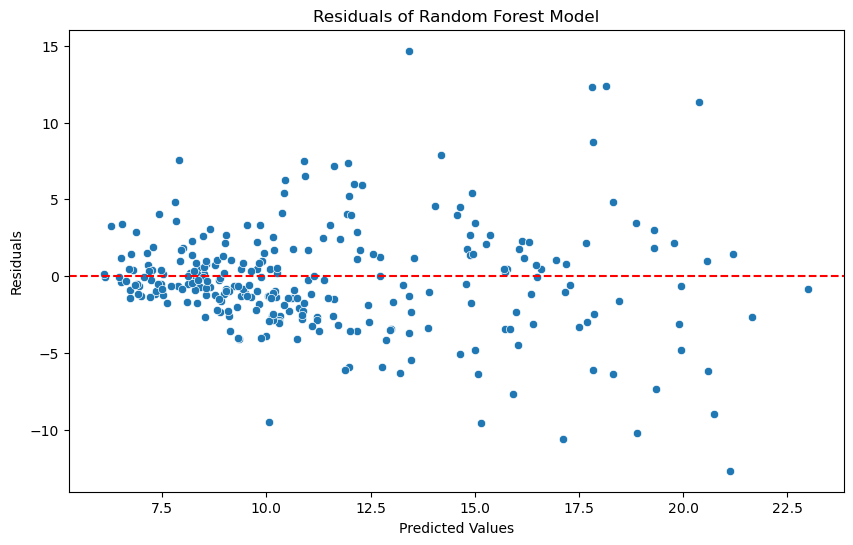

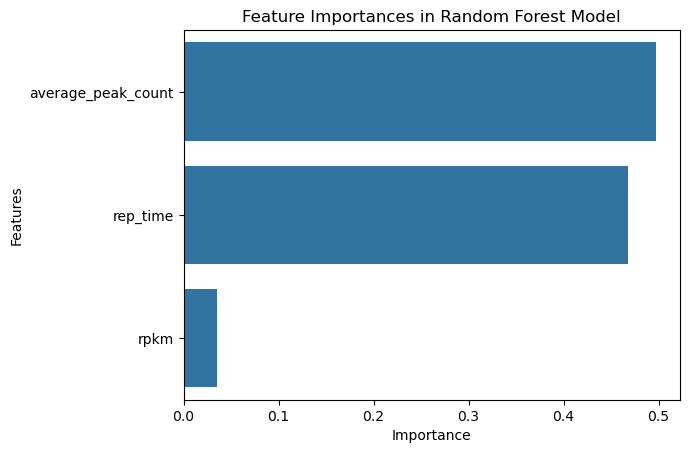

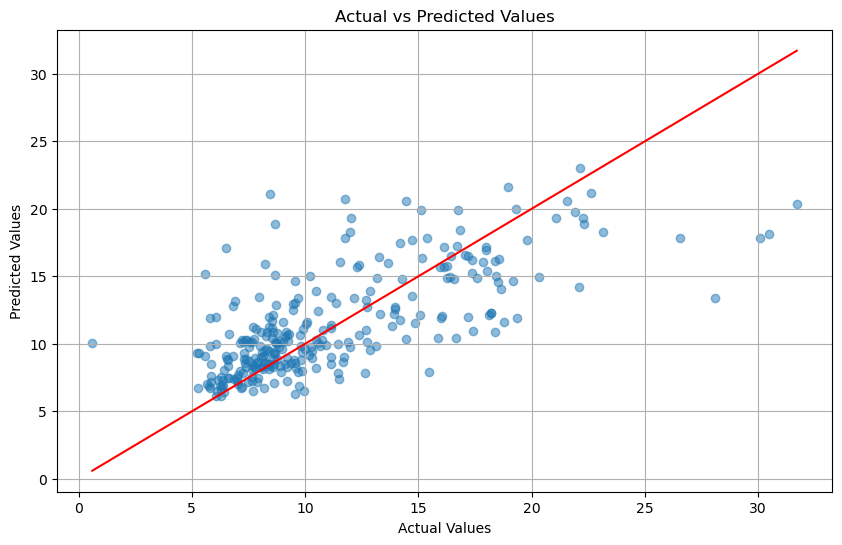

In [33]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Preparing the data
X = model_input_I[['average_peak_count', 'rep_time', 'rpkm']]  # Predictor variables
y = model_input_I['normalized_mutation_count']  # Target variable

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Random Forest model
rf_model = RandomForestRegressor(n_estimators=1000, oob_score=True, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Baseline Model - Linear Regression for comparison
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# Evaluations
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
oob_score = rf_model.oob_score_
pearson_corr_rf = np.corrcoef(y_test, y_pred_rf)[0, 1]

mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
pearson_corr_lr = np.corrcoef(y_test, y_pred_lr)[0, 1]

print(f"Random Forest MSE: {mse_rf}")
print(f"Random Forest R^2: {r2_rf}")
print(f"Random Forest OOB Score: {oob_score}")
print(f"Random Forest Pearson Correlation: {pearson_corr_rf}")
print(f"Linear Regression MSE: {mse_lr}")
print(f"Linear Regression R^2: {r2_lr}")
print(f"Linear Regression Pearson Correlation: {pearson_corr_lr}")

# Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_rf = cross_val_score(rf_model, X, y, cv=kf, scoring='r2')
cv_scores_lr = cross_val_score(lr_model, X, y, cv=kf, scoring='r2')

print(f"Random Forest CV R^2 scores: {cv_scores_rf}")
print(f"Linear Regression CV R^2 scores: {cv_scores_lr}")

# Residuals Plot for Random Forest
residuals_rf = y_test - y_pred_rf
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_rf, y=residuals_rf)
plt.title('Residuals of Random Forest Model')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

# Feature Importance
feature_importances = rf_model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Features': features, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)
sns.barplot(x='Importance', y='Features', data=importance_df)
plt.title('Feature Importances in Random Forest Model')
plt.show()

# Plotting Actual vs Predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
# Plotting the identity line
line = np.linspace(min(y_test.min(), y_pred_rf.min()), max(y_test.max(), y_pred_rf.max()), 1000)
plt.plot(line, line, color='red')  # Identity line for reference
plt.grid(True)
plt.show()


In [34]:
feature_importances

array([0.49731151, 0.46739085, 0.03529763])

# Healthy Colorectal Chromatin Accessibility (via ENCODE)

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import os
# Change the current working directory
new_directory = '/Users/suryav/proj/alignpatient'
os.chdir(new_directory)
# Get a list of all .txt files in the current directory
txt_files = [file for file in os.listdir() if file.endswith(".txt")]

# Initialize a dictionary to store total peak values for each chromosome and peak
total_peak_values = {}
peak_counts = {}

# Process each file
for txt_file in txt_files:
    # Read the data from the current file
    file_path = os.path.join(os.getcwd(), txt_file)
    data = pd.read_csv(file_path, sep="\t", header=None, names=['chrom', 'start', 'end', 'peak_id', 'value'])

    # Process each row in the file
    for index, row in data.iterrows():
        chrom, start, end, peak_id, value = row

        # Use the peak ID as a unique identifier for peaks
        peak_key = (chrom, start, end, peak_id)
        
        if peak_key not in total_peak_values:
            total_peak_values[peak_key] = 0
            peak_counts[peak_key] = 0
        
        total_peak_values[peak_key] += value
        peak_counts[peak_key] += 1

# Calculate average peak values for each peak
primaryChrom_v_RepTime = {peak_key: total / peak_counts[peak_key] for peak_key, total in total_peak_values.items()}

# Convert to DataFrame for easier handling and plotting
control_avg_peak = pd.DataFrame(primaryChrom_v_RepTime.items(), columns=['Peak_Info', 'Average_Value'])
control_avg_peak[['Chrom', 'Start', 'End', 'Peak_ID']] = pd.DataFrame(control_avg_peak['Peak_Info'].tolist(), index=control_avg_peak.index)
control_avg_peak.drop('Peak_Info', axis=1, inplace=True)

# Group by chromosome for plotting
grouped = control_avg_peak.groupby('Chrom')

# for chrom, group in grouped:
#     plt.figure(figsize=(10, 6))
#     plt.scatter(group['Start'], group['Average_Value'], label=f'Average Peak Value for {chrom}')
#     plt.title(f'Average Peak Value for {chrom}')
#     plt.xlabel('Position (bp)')
#     plt.ylabel('Average Peak Value')
#     plt.grid(True)
#     plt.legend()
#     plt.tight_layout()
#     plt.show()


In [36]:
import numpy as np

# Define the window size (1 Mb = 1,000,000 base pairs)
window_size = 1_000_000

# Initialize a list to store the results
window_averages = []

# Iterate over each chromosome present in the DataFrame
for chrom in control_avg_peak['Chrom'].unique():
    # Filter the DataFrame for the current chromosome
    chrom_df = control_avg_peak[control_avg_peak['Chrom'] == chrom]

    # Find the max position for the current chromosome to define the last window
    max_position = chrom_df['End'].max()

    # Create windows of 1Mb along the chromosome
    for window_start in range(0, max_position, window_size):
        window_end = window_start + window_size

        # Filter peaks within the current window
        # A peak is considered within the window if its start is <= window_end and its end > window_start
        window_peaks = chrom_df[(chrom_df['Start'] <= window_end) & (chrom_df['End'] > window_start)]

        # Calculate the average of the average peak values within this window
        if not window_peaks.empty:
            window_avg = window_peaks['Average_Value'].mean()
            window_averages.append({'Chrom': chrom, 'Window_Start': window_start, 'Window_End': window_end, 'Average_Peak_Value': window_avg})

# Convert the results into a DataFrame
window_averages_df = pd.DataFrame(window_averages)

# Rename the 'Window_Start' column and drop the 'Window_End' column
window_averages_df.rename(columns={'Chrom':'chrom','Window_Start': 'window_index', 'Average_Peak_Value': 'average_peak_count'}, inplace=True)
window_averages_df.drop('Window_End', axis=1, inplace=True)
window_averages_df['window_index'] = window_averages_df['window_index']/1e6
# Now window_avg_df has the columns adjusted as per your request
windowAvgs = window_averages_df
print(windowAvgs)

     chrom  window_index  average_peak_count
0     chr1           0.0            0.463696
1     chr1           1.0            0.642035
2     chr1           2.0            0.284474
3     chr1           3.0            0.351879
4     chr1           4.0            0.022654
...    ...           ...                 ...
2900  chrX         152.0            0.176802
2901  chrX         153.0            0.467790
2902  chrX         154.0            0.824728
2903  chrX         155.0            0.640000
2904  chrX         156.0            0.008333

[2905 rows x 3 columns]


# Spearman Correlation: Healthy Chromatin Accessibility &. Primary SNVs

In [37]:
from scipy.stats import spearmanr
ob = pd.merge(windowAvgs, snv_counts_df, on=['chrom', 'window_index'], how='inner')


spearman_corr, p_value = spearmanr(ob['average_peak_count'], ob['snv_count'])
print(spearman_corr, p_value)


-0.542616966044447 2.2223715039324066e-221


# Spearman Correlation: Healthy Chromatin Accessibility & Metastatic SNVs

In [38]:
from scipy.stats import spearmanr
cc = pd.merge(windowAvgs, mutation_df, on=['chrom', 'window_index'], how='inner')


spearman_corr, p_value = spearmanr(cc['average_peak_count'], cc['normalized_mutation_count'])
print(spearman_corr, p_value)


-0.606532437669336 1.3502830457167645e-286


# Random Forest (II)
### Inputting healthy colorectal chromatin accessibility, instead of the primary colorectal chromatin accessibility, to the same Random Forest model 

In [39]:
healthyChromatinAccess = pd.merge(model_input_I, windowAvgs, on=['chrom', 'window_index'], how='inner')


In [40]:
healthyChromatinAccess = pd.merge(healthyChromatinAccess, snv_counts_df, on=['chrom', 'window_index'], how='inner')


In [41]:
healthyChromatinAccess

,chrom,window_index,average_peak_count_x,normalized_mutation_count,rpkm,rep_time,average_peak_count_y,snv_count
0,chr1,0.0,4.601876,2.609890,0,0.850914,0.463696,7.980769
1,chr1,1.0,11.100515,6.933379,6093,0.958809,0.642035,21.057692
2,chr1,2.0,4.723746,8.198718,5240,0.267606,0.284474,28.884615
3,chr1,3.0,3.599641,7.533196,9,0.065517,0.351879,29.557692
4,chr1,4.0,0.131068,12.891484,0,-1.513787,0.022654,66.980769
...,...,...,...,...,...,...,...,...
2810,chrX,150.0,0.981963,9.588828,0,0.742630,0.217228,38.192308
2811,chrX,151.0,1.439041,9.230769,0,-1.318921,0.282700,37.980769
2812,chrX,152.0,0.955903,5.527701,0,-0.345450,0.176802,22.730769
2813,chrX,153.0,4.242441,5.296245,0,0.827638,0.467790,19.230769


In [42]:
from scipy.stats import spearmanr

spearman_corr, p_value = spearmanr(healthyChromatinAccess['average_peak_count_x'], healthyChromatinAccess['average_peak_count_y'])
print(spearman_corr, p_value)

0.8733658430285363 0.0


Random Forest MSE: 13.622918225653994
Random Forest R^2: 0.44203794689109155
Random Forest OOB Score: 0.3881580365317969
Random Forest Pearson Correlation: 0.6664711493777088
Linear Regression MSE: 15.163114523121397
Linear Regression R^2: 0.37895520102924485
Linear Regression Pearson Correlation: 0.6156788764760213
Random Forest CV R^2 scores: [0.32544481 0.41552543 0.35595035 0.45925917 0.4367213 ]
Linear Regression CV R^2 scores: [0.40276627 0.37730979 0.38109816 0.461428   0.36967457]


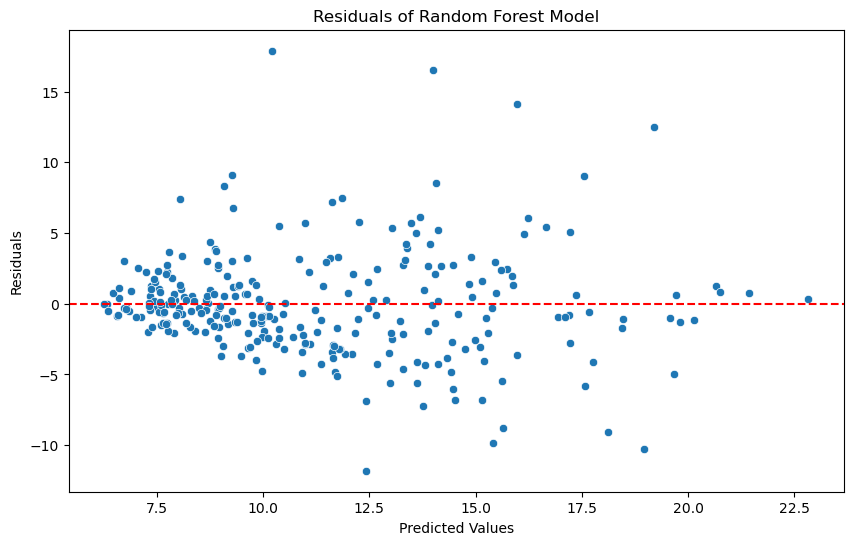

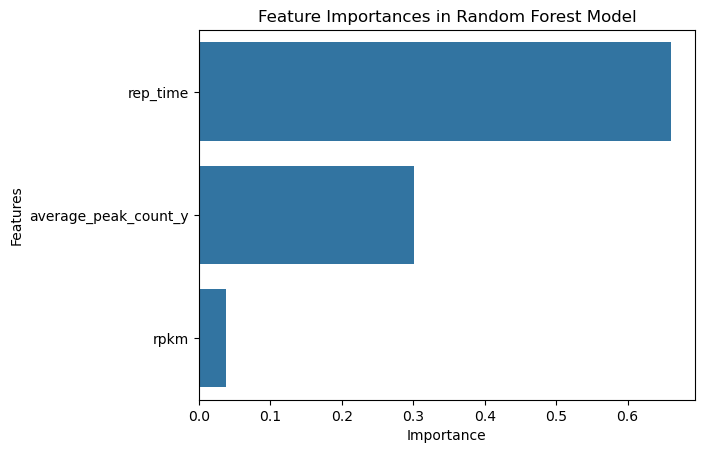

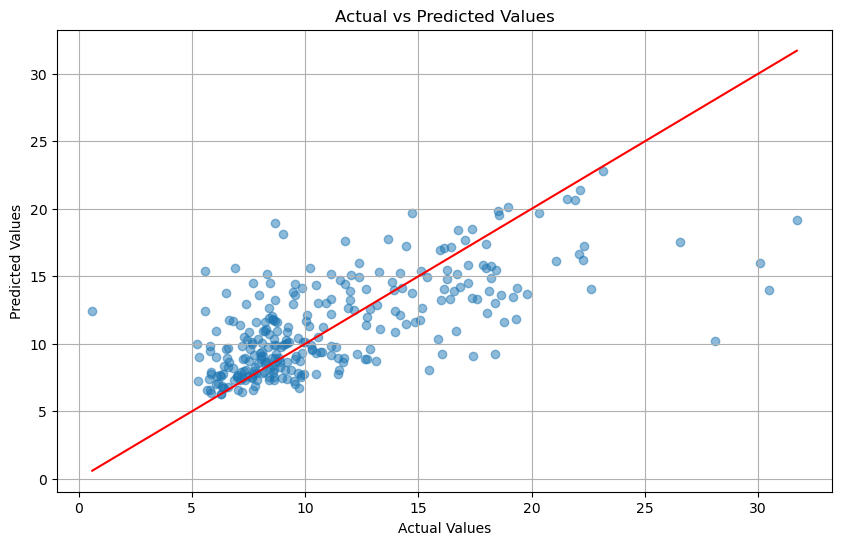

In [43]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Preparing the data
X = healthyChromatinAccess[['average_peak_count_y', 'rep_time', 'rpkm']]  # Predictor variables
y = healthyChromatinAccess['normalized_mutation_count']  # Target variable

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Random Forest model
rf_model = RandomForestRegressor(n_estimators=1000, oob_score=True, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Baseline Model - Linear Regression for comparison
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# Evaluations
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
oob_score = rf_model.oob_score_
pearson_corr_rf = np.corrcoef(y_test, y_pred_rf)[0, 1]

mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
pearson_corr_lr = np.corrcoef(y_test, y_pred_lr)[0, 1]

print(f"Random Forest MSE: {mse_rf}")
print(f"Random Forest R^2: {r2_rf}")
print(f"Random Forest OOB Score: {oob_score}")
print(f"Random Forest Pearson Correlation: {pearson_corr_rf}")
print(f"Linear Regression MSE: {mse_lr}")
print(f"Linear Regression R^2: {r2_lr}")
print(f"Linear Regression Pearson Correlation: {pearson_corr_lr}")

# Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_rf = cross_val_score(rf_model, X, y, cv=kf, scoring='r2')
cv_scores_lr = cross_val_score(lr_model, X, y, cv=kf, scoring='r2')

print(f"Random Forest CV R^2 scores: {cv_scores_rf}")
print(f"Linear Regression CV R^2 scores: {cv_scores_lr}")

# Residuals Plot for Random Forest
residuals_rf = y_test - y_pred_rf
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_rf, y=residuals_rf)
plt.title('Residuals of Random Forest Model')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

# Feature Importance
feature_importances = rf_model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Features': features, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)
sns.barplot(x='Importance', y='Features', data=importance_df)
plt.title('Feature Importances in Random Forest Model')
plt.show()

# Plotting Actual vs Predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
# Plotting the identity line
line = np.linspace(min(y_test.min(), y_pred_rf.min()), max(y_test.max(), y_pred_rf.max()), 1000)
plt.plot(line, line, color='red')  # Identity line for reference
plt.grid(True)
plt.show()


In [44]:
feature_importances

array([0.30043143, 0.66103392, 0.03853465])